### Описание проекта
**Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.   
Задача — разобраться в причинах.**   

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:  
лог сервера с данными об их посещениях,  
выгрузка их покупок за этот период,  
рекламные расходы.  

  
Необходимо изучить:  
откуда приходят пользователи и какими устройствами они пользуются,  
сколько стоит привлечение пользователей из различных рекламных каналов,  
сколько денег приносит каждый клиент,  
когда расходы на привлечение клиента окупаются,  
какие факторы мешают привлечению клиентов.

### Предобработка данных

In [39]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#чтение данных
try:
    visits = pd.read_csv('/Users/marinakravets/Downloads/visits_info_short.csv')
    orders = pd.read_csv('/Users/marinakravets/Downloads/orders_info_short.csv')
    costs_i = pd.read_csv('/Users/marinakravets/Downloads/costs_info_short (1).csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs_i = pd.read_csv('/datasets/costs_info_short.csv')

    print(visits.info())


In [3]:
# приведение названий столбцов к нижнему регистру
visits.columns = visits.columns.str.lower()
# добавление нижнего подчеркивания для избавления между словами
visits = visits.rename(columns={'user id':'user_id', 'session start':'session_start', 'session end':'session_end'})
# приведение колонок с датами к формату дата
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [4]:
# проверка на явные дубликаты
visits.duplicated().sum()

0

In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [6]:
# приведение названий столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()
# добавление нижнего подчеркивания для избавления между словами
orders = orders.rename(columns = {'user id':'user_id', 'event dt':'event_dt'})
# приведение колонок с датами к формату дата
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [8]:
# проверка на явные дубликаты
orders.duplicated().sum()

0

In [9]:
costs_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [10]:
# приведение названий столбцов к нижнему регистру
costs_i= costs_i.rename(columns={'Channel':'channel'})
costs_i['dt'] = pd.to_datetime(costs_i['dt']).dt.date
costs_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [11]:
# проверка на явные дубликаты
costs_i.duplicated().sum()

0

### Исследовательский анализ данных

Составим профили пользователей.   
Определим минимальную и максимальную даты привлечения пользователей.  
Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.   
Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.   
Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.  

#### Портрет пользователя

In [12]:
# находим параметры первых посещений
profiles = (
    visits.sort_values(by=['user_id', 'session_start'])
    .groupby('user_id')
    .agg(
        {'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
    )
    .rename(columns={'session_start': 'first_ts'})
    .reset_index()
)

# для когортного анализа определяем дату первого посещения
# и первый день месяца, в который это посещение произошло
profiles['dt'] = profiles['first_ts'].dt.date
profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

# добавляем признак платящих пользователей
profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

# считаем количество уникальных пользователей
# с одинаковыми источником и датой привлечения
new_users = (
    profiles.groupby(['dt', 'channel'])
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_users'})
    .reset_index()
)

# объединяем траты на рекламу и число привлечённых пользователей
ad_costs = costs_i.merge(new_users, on=['dt', 'channel'], how='left')

# делим рекламные расходы на число привлечённых пользователей
ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
# добавляем стоимость привлечения в профили
profiles = profiles.merge(
    ad_costs[['dt', 'channel', 'acquisition_cost']],
    on=['dt', 'channel'],
    how='left',
)

# стоимость привлечения органических пользователей равна нулю
profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

profiles.head(10)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:23,organic,Android,United States,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,Android,United States,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


In [13]:
#минимальная дата привлечения пользователей
profiles['first_ts'].min()

Timestamp('2019-05-01 00:00:41')

In [14]:
#максимальная дата привлечения пользователей
profiles['first_ts'].max()

Timestamp('2019-10-27 23:59:04')

#### Страны, в которых используют приложение

In [15]:
#Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
profiles_region = profiles.groupby('region').agg({'user_id':'nunique','payer':'mean'}).reset_index()
profiles_region.columns = ['страна','кол-во пользователей', 'доля платящих']
profiles_region['доля страны'] =profiles_region['кол-во пользователей']/ profiles_region['кол-во пользователей'].sum()*100
profiles_region

,страна,кол-во пользователей,доля платящих,доля страны
0,France,17450,0.037994,11.632713
1,Germany,14981,0.041119,9.986801
2,UK,17575,0.039829,11.716042
3,United States,100002,0.069019,66.664445


Пользователи приходят в приложение из Франции 11%, Германии 10% и Великобритании 12% и США 67%. Больше всего доля платящих клиентов в США - она составляет 7% от всех пользователей. В остальных странах примерно одинаково - около 4%

#### Устройства, которые используют пользователи

In [16]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
profiles_region = profiles.groupby('device').agg({'user_id':'nunique','payer':'mean'}).reset_index()
profiles_region.columns = ['устройство','кол-во пользователей', 'доля платящих']
profiles_region

,устройство,кол-во пользователей,доля платящих
0,Android,35032,0.058518
1,Mac,30042,0.063644
2,PC,30455,0.050468
3,iPhone,54479,0.062079


Самым популярным устройством для использования приложения является IPhone.  
Платящих пользоваталей на Android,Mac и IPhone примерно одинаково и составляет 6%, на PC - люди склонны менее покупать, только 5% 

#### Источники привлечения пользователей

In [17]:
#Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
profiles_channel = profiles.groupby('channel').agg({'user_id':'nunique','payer':'sum'}).sort_values(by='user_id', ascending=False).reset_index()
profiles_channel.columns = ['источник','кол-во пользователей', 'кол-во покупателей']
profiles_channel

,источник,кол-во пользователей,кол-во покупателей
0,organic,56439,1160
1,FaceBoom,29144,3557
2,TipTop,19561,1878
3,OppleCreativeMedia,8605,233
4,LeapBob,8553,262
5,WahooNetBanner,8553,453
6,RocketSuperAds,4448,352
7,MediaTornado,4364,156
8,YRabbit,4312,165
9,AdNonSense,3880,440


Больше всего пользователей приходят сами, из бесплатного источника, но доля платящих составляет 2% или 1160 чел  
На втором месте по привлечению пользователей источник - FaceBoom и доля платящих составляет 12% или 3557 чел  
На третьем месте источник TipTop с долей платящих пользователей 10% или 1878 чел  

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

#### Сумма расходов на маркетинг

In [18]:
costs_i.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [19]:
#Найдем общую сумму расходов на маркетинг.
total_costs = costs_i['costs'].sum()
total_costs

105497.30000000002

Сумма расходов на маркетинг составляет 105497

#### Распределение расходов по рекламным источникам

In [20]:
#Составим таблицу как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
costs_channel =costs_i.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)
costs_channel['Доля'] = round(costs_channel['costs']/total_costs*100)
costs_channel

,costs,Доля
channel,,
TipTop,54751.30,52.0
FaceBoom,32445.60,31.0
WahooNetBanner,5151.00,5.0
AdNonSense,3911.25,4.0
OppleCreativeMedia,2151.25,2.0
RocketSuperAds,1833.00,2.0
LeapBob,1797.60,2.0
lambdaMediaAds,1557.60,1.0
MediaTornado,954.48,1.0


Больше всего денег потратили на такие источники рекламы как: TipTop - 52% рекламного бюджета, FaceBoom - 31%, WahooNetBanner - 5%

#### Динамика изменения расходов по времени по каждому источнику

In [21]:
#Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
#преобразуем формат
costs_i['dt'] = pd.to_datetime(costs_i['dt'])
#добавим колонку с данными по неделям
costs_i['week'] = costs_i['dt'].dt.isocalendar().week
#добавим колонку с данными по месяцам
costs_i['month'] = costs_i['dt'].dt.month

In [22]:
costs_i.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


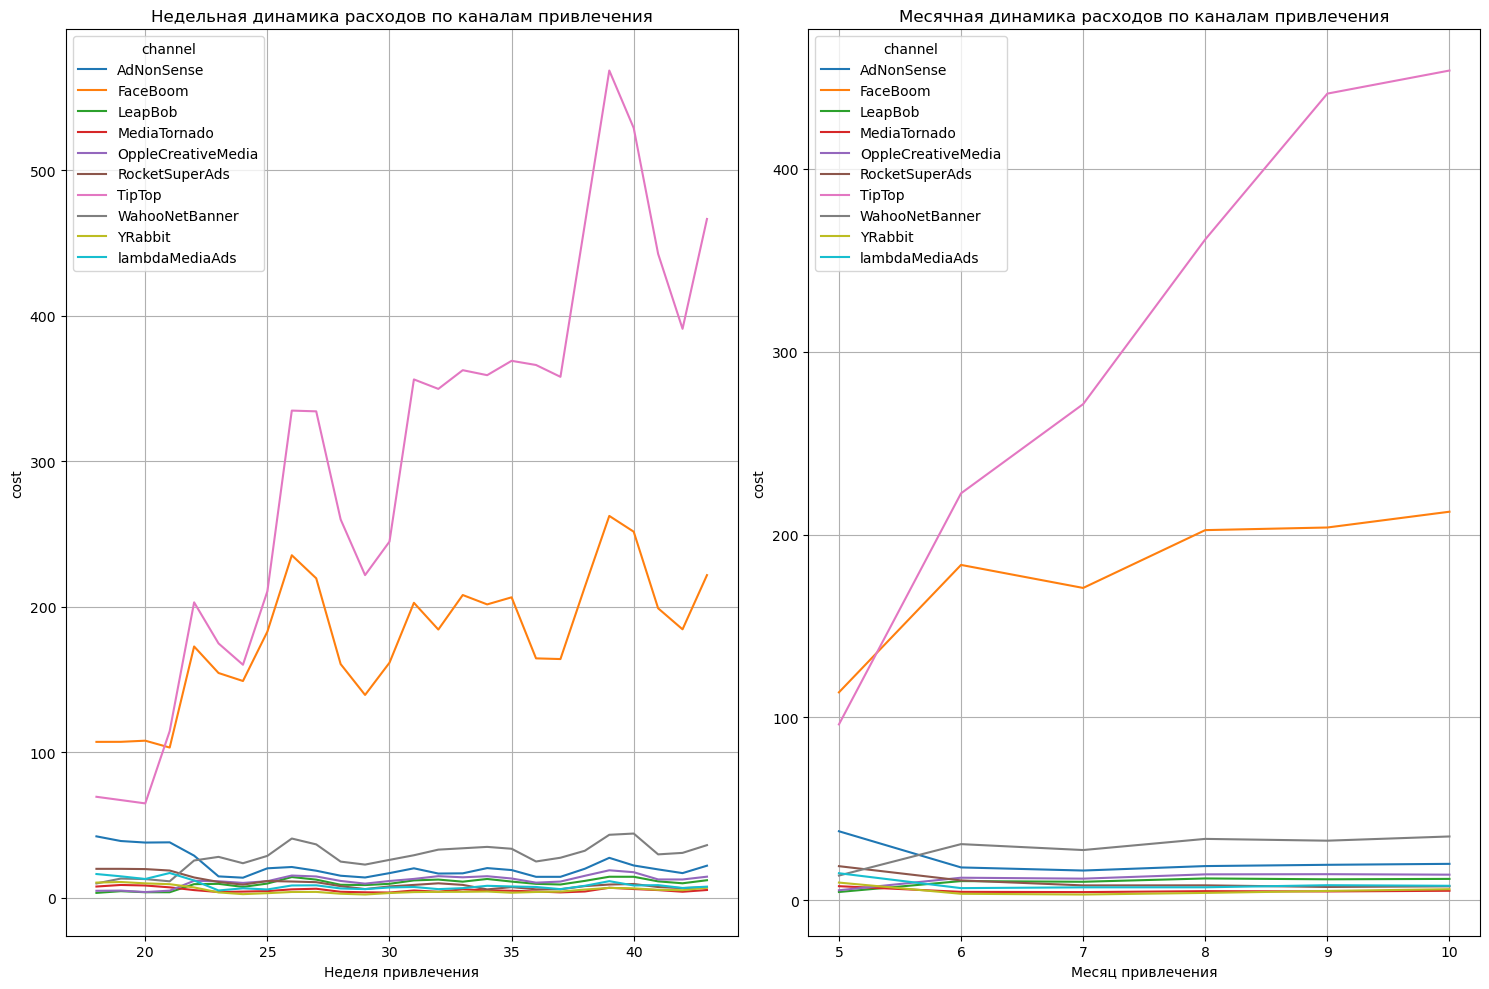

In [23]:
# построим графики
plt.figure(figsize=(15, 10))
ax1=plt.subplot(1,2,1)
costs_i.pivot_table(
    index='week', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, ax=ax1)
plt.ylabel('cost')
plt.xlabel('Неделя привлечения')
plt.title('Недельная динамика расходов по каналам привлечения')

ax2=plt.subplot(1,2,2)
costs_i.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='mean'
).plot(grid=True, ax=ax2)
plt.ylabel('cost')
plt.xlabel('Месяц привлечения')
plt.title('Месячная динамика расходов по каналам привлечения')
plt.tight_layout()
plt.show()

Динамика распределения расходов по источникам по неделям и месяцам показываем ровные расходы на рекламу во всех источниках, кроме TipTop и FaceBoom. В этих источниках рост расходов от месяца к месяцу

#### Средняя стоимость привлечения одного пользователя

In [24]:
#Построим таблицу средних рекламных расходов на 1 пользователя по источникам
cac_avarage = profiles.groupby('channel').agg({'acquisition_cost':'median'}).sort_values(by='acquisition_cost', ascending=False)
cac_avarage

,acquisition_cost
channel,
TipTop,3.000000
FaceBoom,1.114667
AdNonSense,1.004348
lambdaMediaAds,0.733333
WahooNetBanner,0.600000
RocketSuperAds,0.404444
OppleCreativeMedia,0.250000
MediaTornado,0.220926
YRabbit,0.214286


В среднем на одного пользователя привлеченного через TipTop компания тратит 3, FaceBoom - 1.1, AdNonSense - 1.  
Самые дешевые YRabbit and LeapBob - 0.21$

In [25]:
cac_total_avarege = cac_avarage['acquisition_cost'].median()
cac_total_avarege

0.4044444444444444

Средний САС по проекту 0.4, что показывает что затраты на такой канал как TipTop в 7,5 раз выше средних затрат по всему проекту

### Окупаемость рекламы

На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [26]:
#отфильтруем данные по органическим пользователям, так как они приходят сами, без затрат
profiles = profiles.query('channel!="organic"')                       

In [27]:
# момент анализа
observation_date = datetime(2019,11,1).date()
#горизонт анализа
horizon_days = 14

#### Анализ окупаемости рекламы

In [28]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [29]:
#Построим таблицы LTV ROI при помощи функции get_ltv
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles, orders, observation_date,horizon_days)

In [30]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [31]:
# функция для визуализации LTV и ROI
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

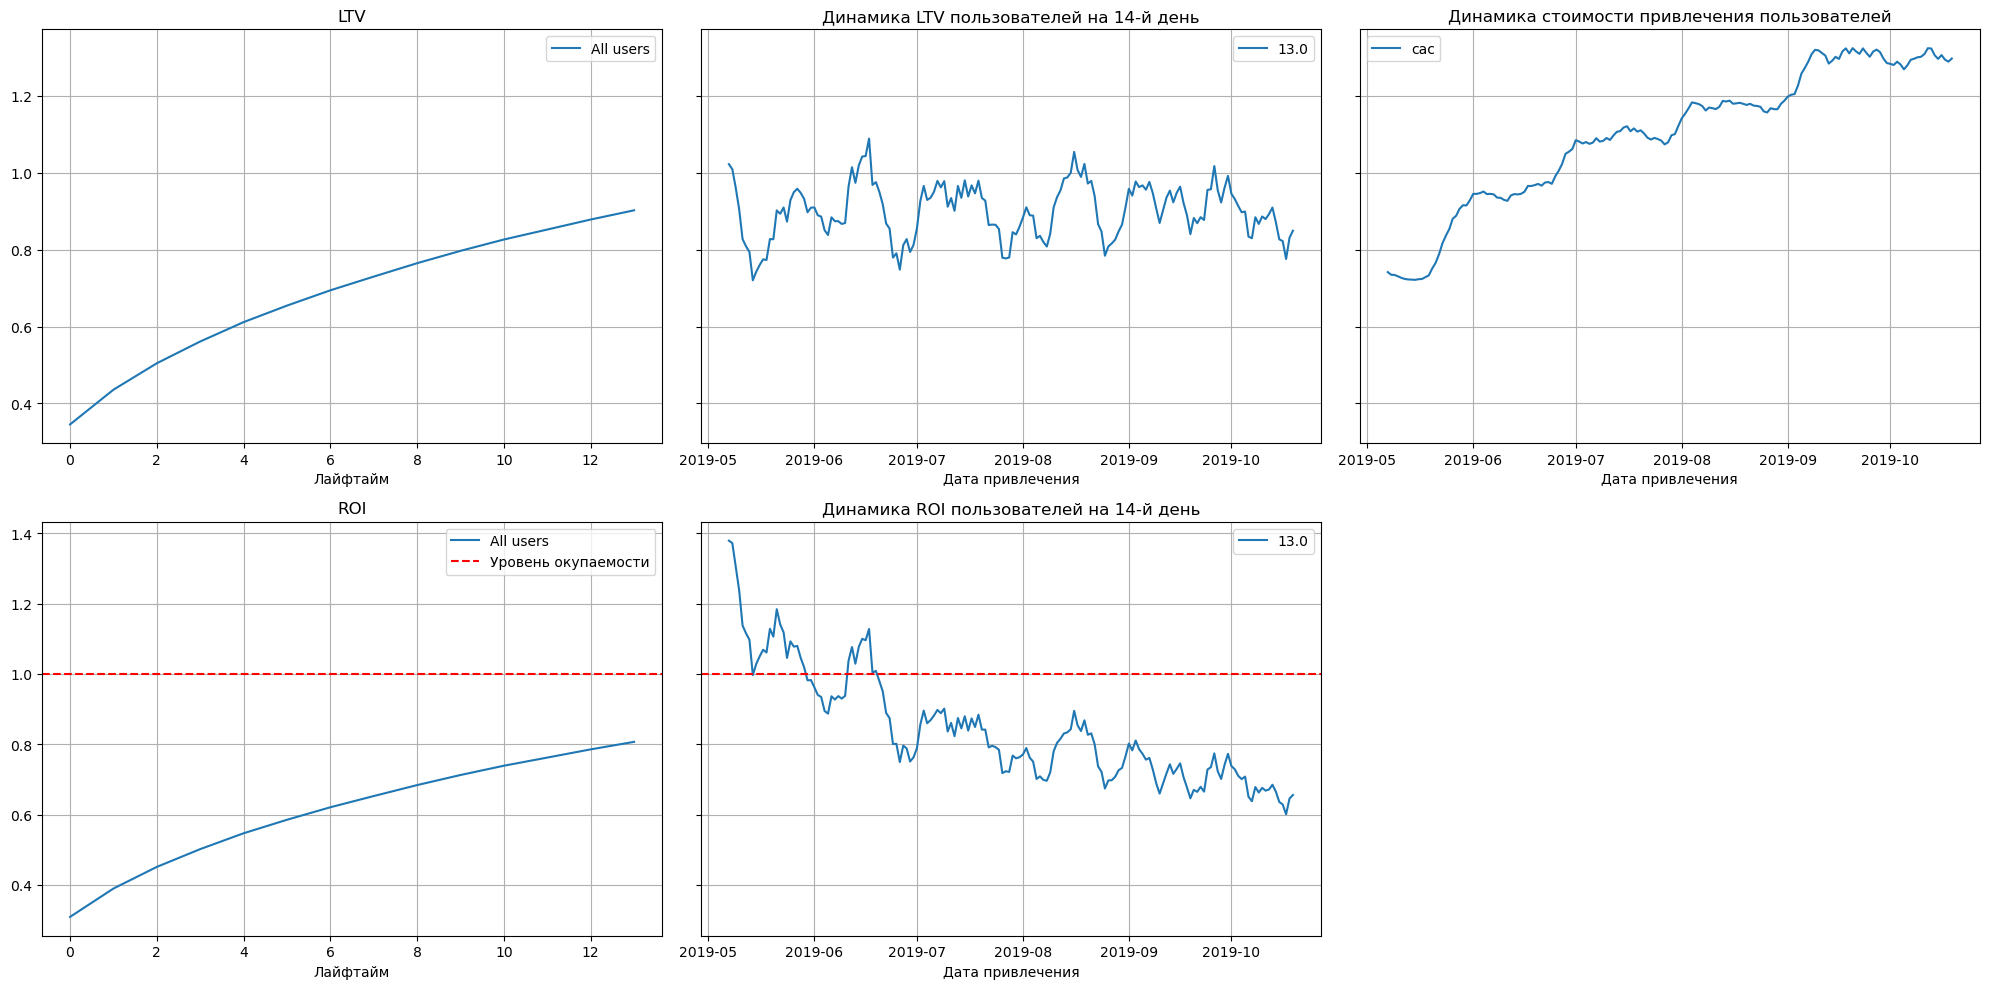

In [32]:
#Построим графики LTV ROI при помощи функции plot_ltv_roi
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7)

LTV - растет, все правильно. Динамика LTV на 14 день ничего критичного,LTV стандартно выше в середине месяца, сезонные колебания.
В отношении продаж все правильно. Но растет CAC- стоимость привлечения клиентов. CAC на начало анализируемого периода 0.3-0.4, а на конец 0.85, в 2 раза выше.  
Хорошо видно на графике Динамика ROI на 14 день, где пользователи привлеченные до середины июля показывали окупаемость продукта, а после середины июля, когда CAC еще возрос, уже окупаемости продукта не стало.

#### Окупаемость рекламы с разбивкой по устройствам

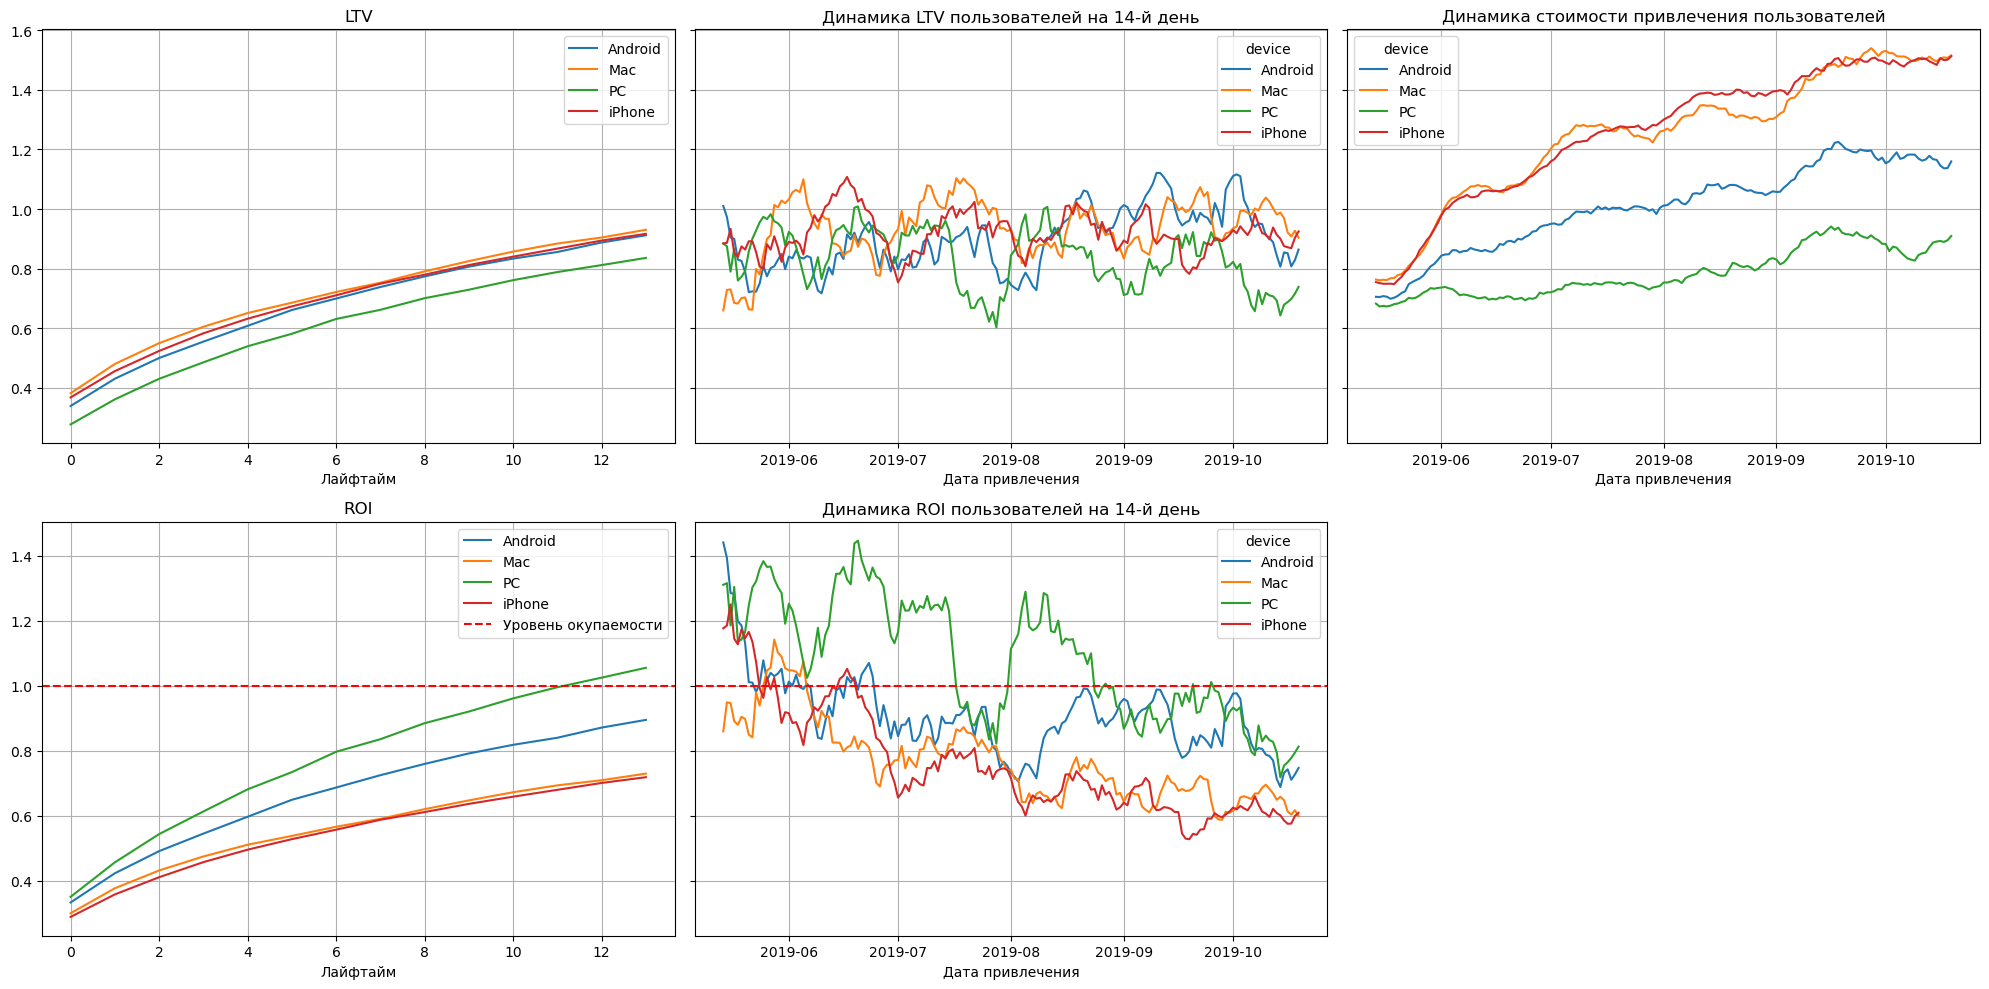

In [33]:
dimensions = ['device']
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Растет CAC особенно на IPhone и MAC. PC начинает окупаться к концу лайфтайма, остальные устройства убыточны

#### Окупаемость рекламы с разбивкой по странам

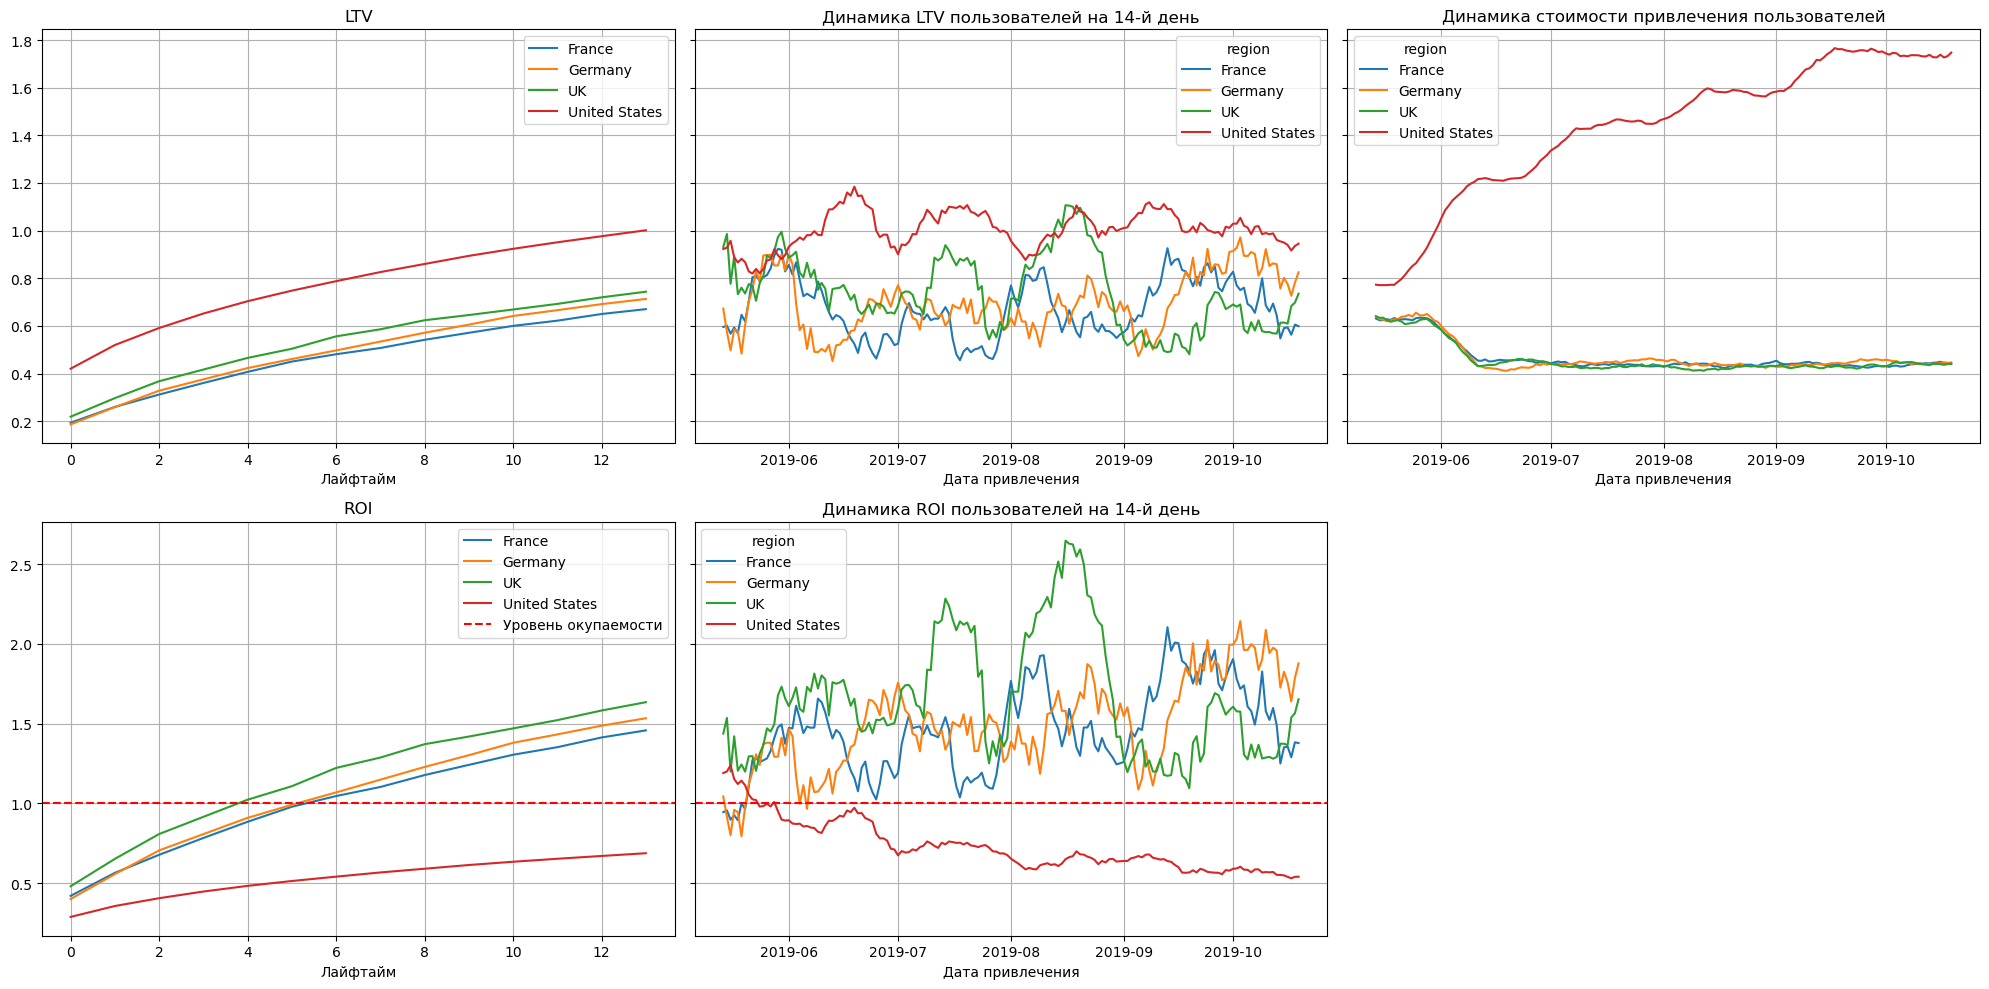

In [34]:
dimensions = ['region']
# используем функцию get_ltv для вывода таблиц ltv roi
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

#графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Не смотря на то, что LTV США выше, чем в других странах, продукт в этой стране вообще не окупается. Это связано с резким ростом CAC  в июне 2019 и дальнейшим постоянным ростом стоимости привлечения пользователей.

#### Окупаемость рекламы с разбивкой по рекламным каналам

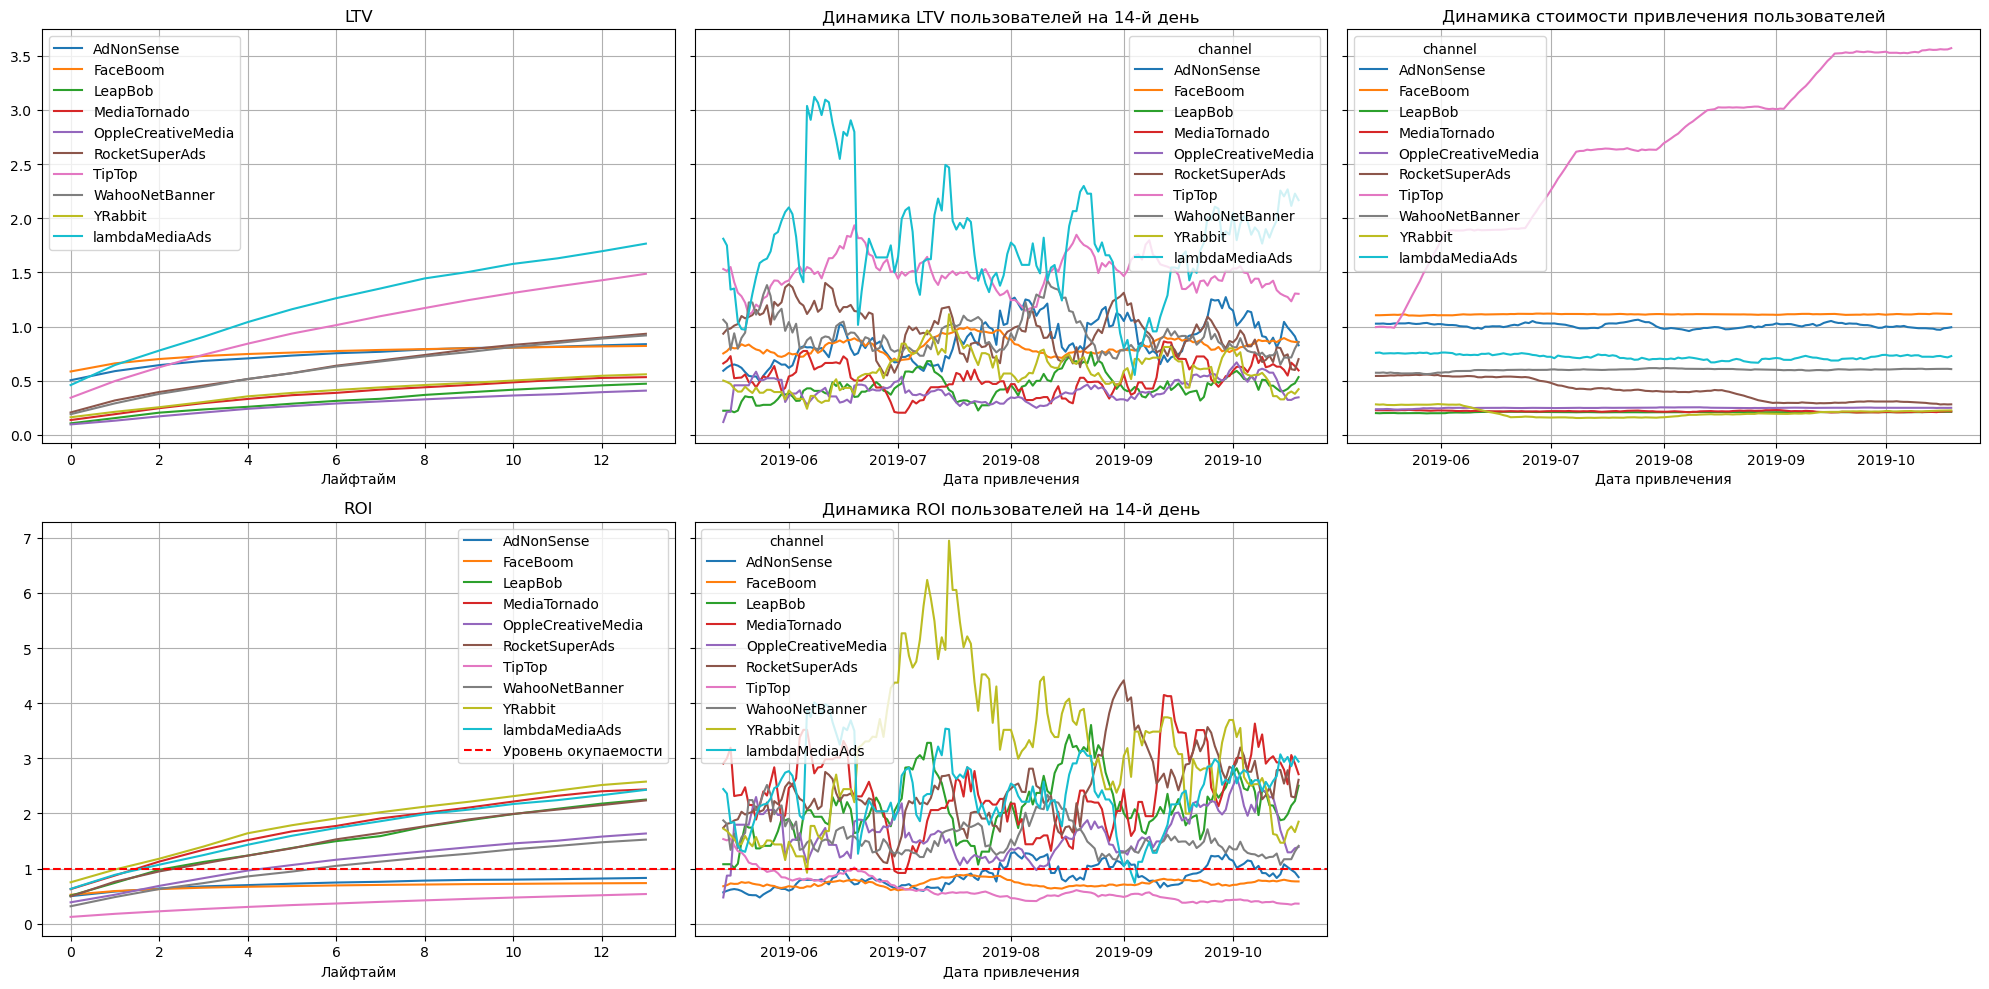

In [35]:

dimensions = ['channel']
# используем функцию get_ltv для вывода таблиц ltv roi
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)
#графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Самый высокий LTV  у lambdaMediaAds, TipTop. Самый низкий показатель LTV у органических пользователей.  
Стремительный рост CAC канала TipTop показал график динамики стоимости привлечения. На остальные каналы затрачиваются стабильные суммы.  
ROI всех каналов, кроме AdNonSense, FaceBoom, TipTop, превышает 1 и окупает затраты.  
Каналы AdNonSense, FaceBoom, TipTop - убыточны, особенно TipTop.

### Окупаемость рекламы в США

Посмотрим отдельно на показатели окупаемости отдельно по США, так как это самая крупная и убыточная страна.  
Определим рекламные каналы и устройства пользователей

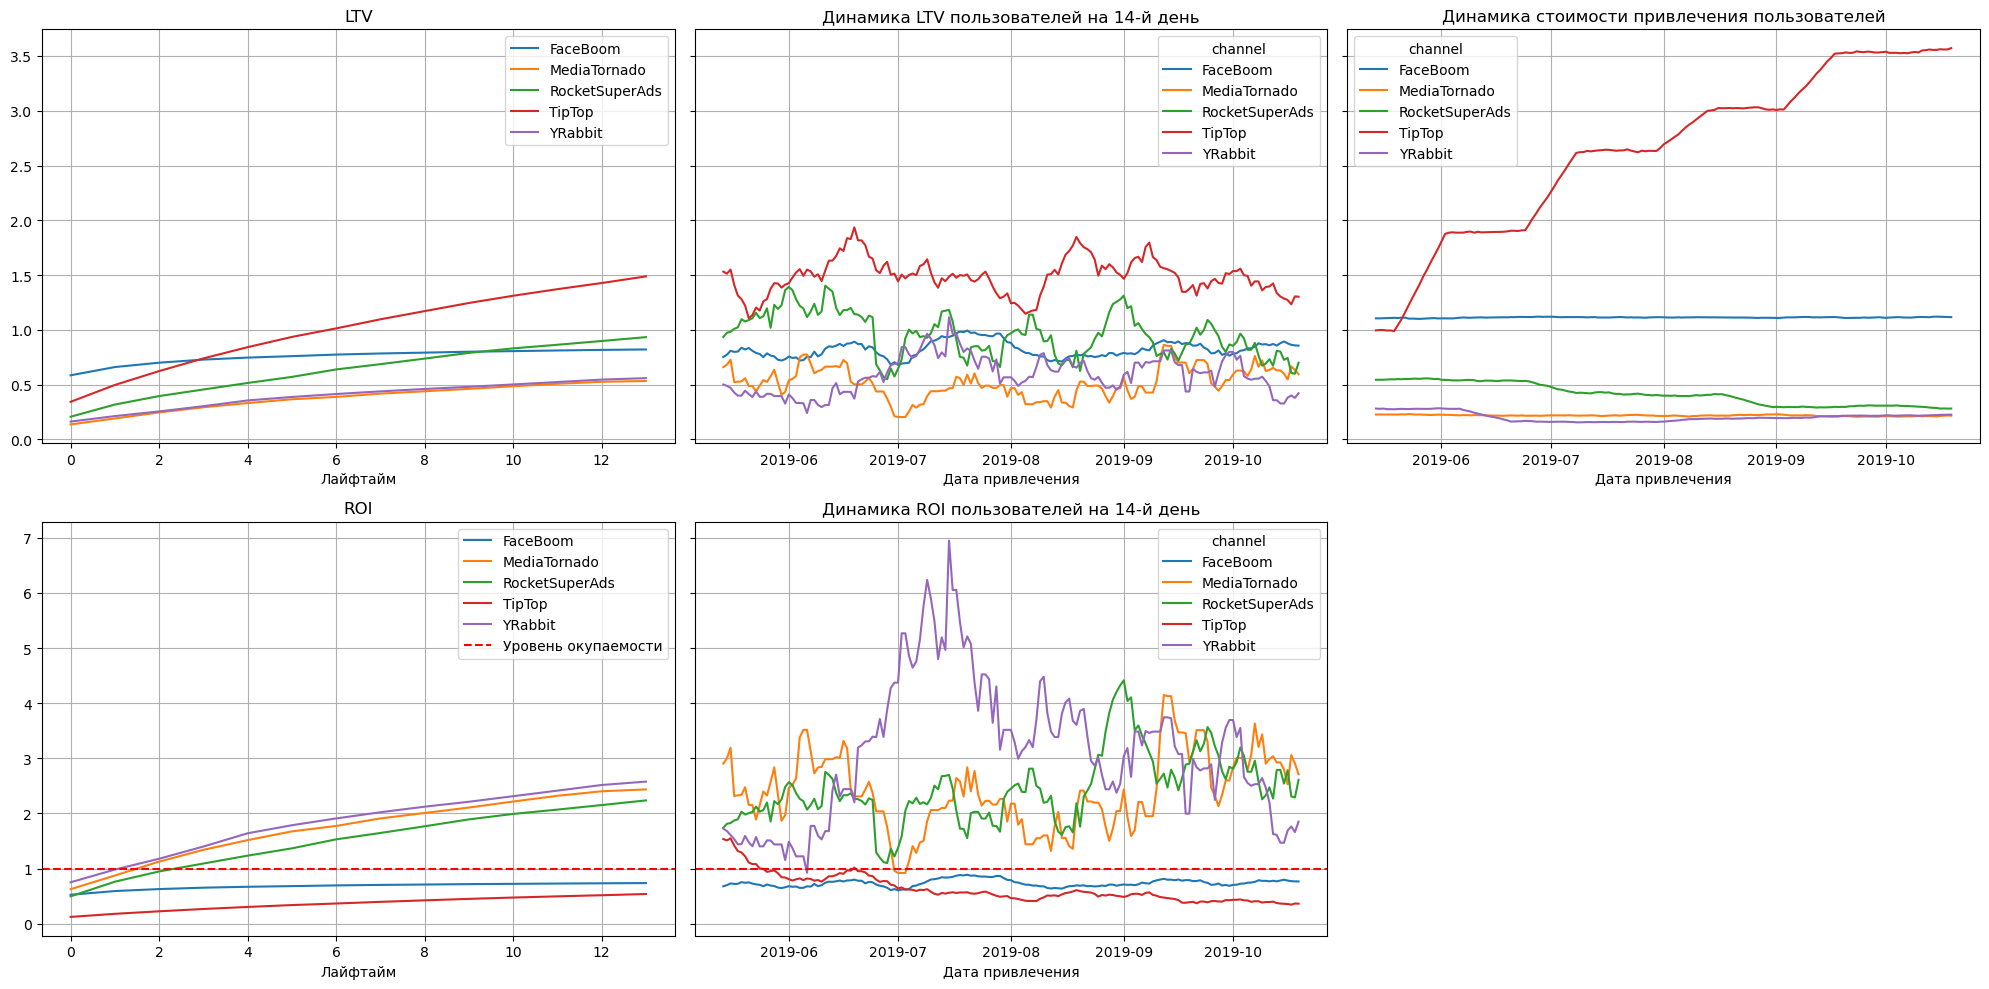

In [36]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region=="United States"'), orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Можно сделать вывод,что каналы TipTop и FaceBoom есть только в США и именно они приносят убытки компании (ROI намного ниже 1). Остальные американские каналы приносят прибыль 

### Окупаемость рекламы в Европе

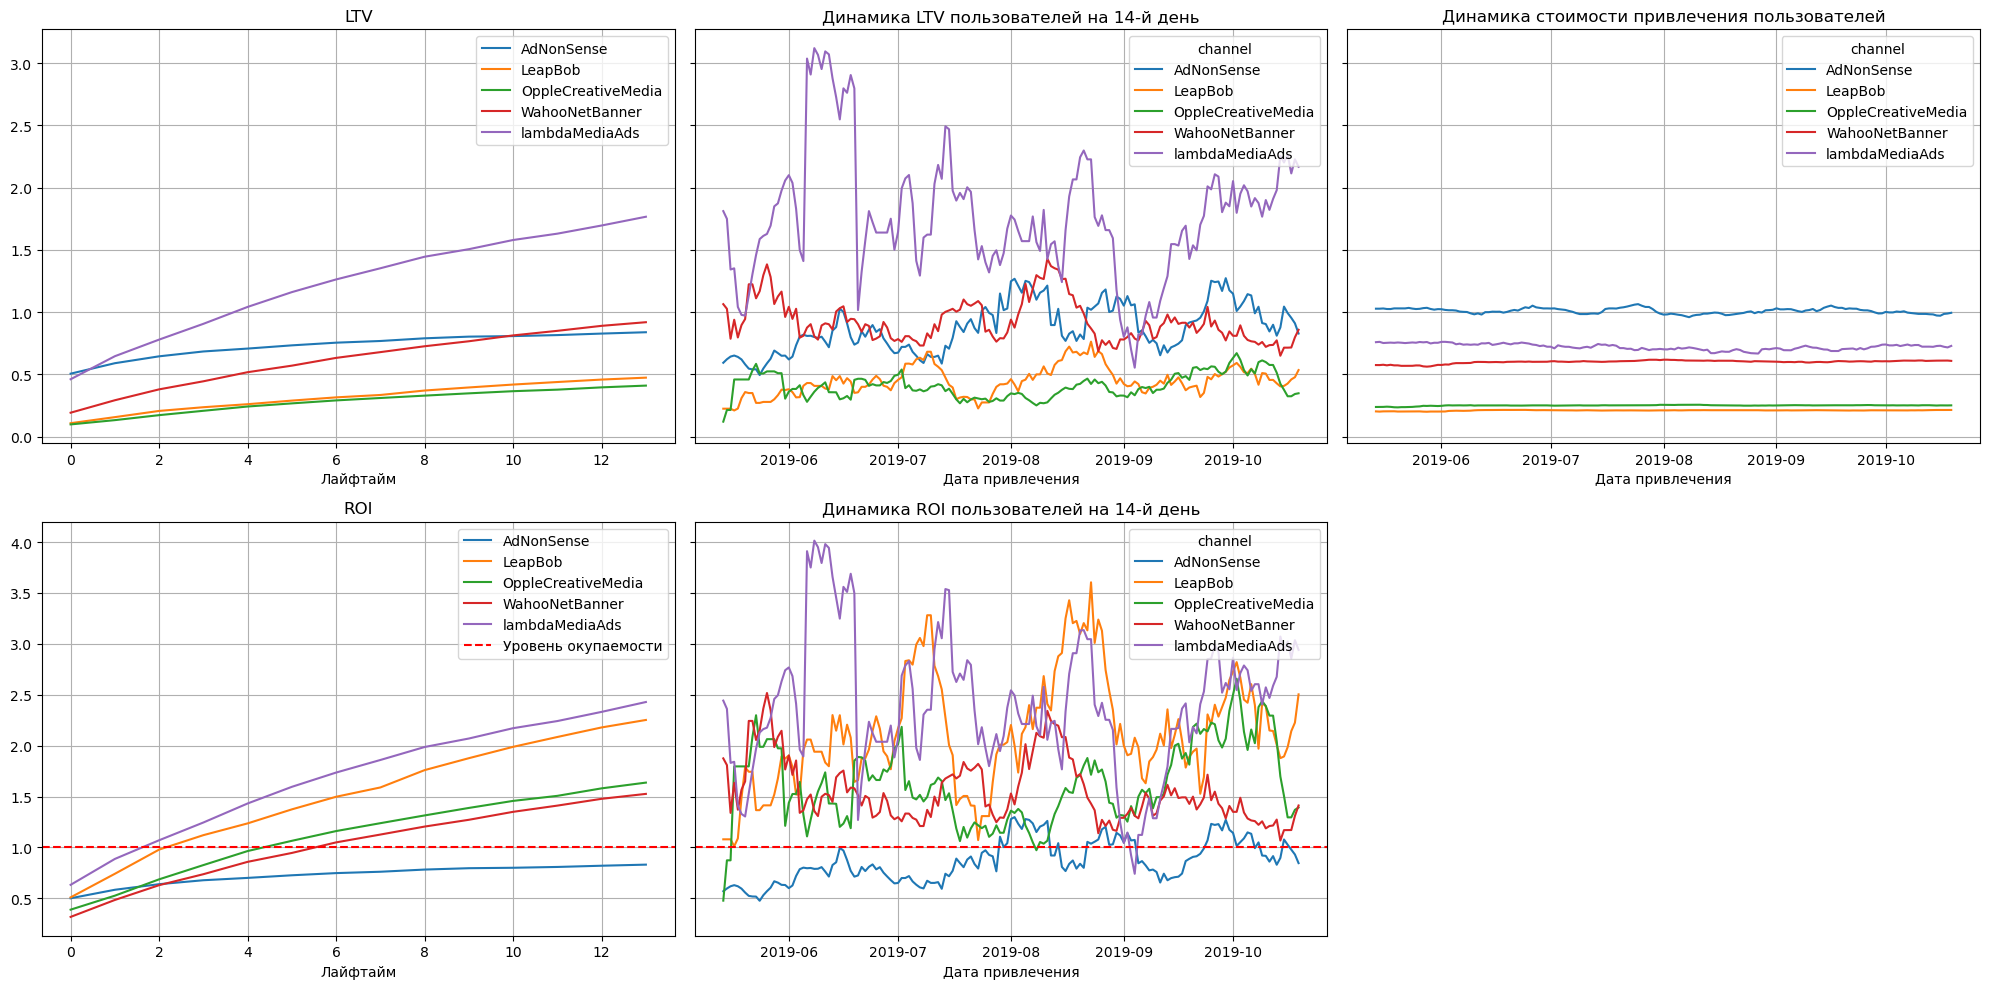

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region!="United States"'), orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Рекламные каналы в Европе прибыльны, за исключением AdNonSense. 

**В целом можно сказать, что реклама, направленная на привлечение покупателей не окупается.  
Основной рынок продаж - это США - 67% пользователей и при этом 7% пользователей - это платящие пользователи.LTV пользователей США самый высокий. Но при этом ROI на уровне 0.7 Что говорит о том, что при высоком количестве пользователей затраты на привлечение этих потребителей еще выше и  рынок США убыточен.  
Страны Франция, Германия и Великобритания занимают каждая около 10% пользователей. ROI в этих странах стабильно окупается начиная со 3 лайфтайма.  
Реклама совсем не окупается от пользователей IPhone и MAC. Реклама на PC приносит прибыль.
Абсолютно убыточные каналы распространения рекламы такие как TipTop (США), FaceBoom (США), AdNonSence(ЕС). С остальными каналами можно работать**

### Выводы



**Главной причиной неээфективности привлечения пользователей я вижу концентрацию усилий и затрат на рынке США.   
Несмотря на большие затраты на рекламу это не приносит ожидаемой прибыли.  
Необходимо сконцентрироваться на развитии рынков Франции, Германии и Великобритании. ROI у этих рынков на уровне 1.8-2. Что позволяет компании увеличить затраты на рекламу в этих регионах. Одновременно снижать затраты на рекламу в США.  
Ориентироваться на пользователей Android и PC.**